In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
import torch
from torch.nn import DataParallel
from torch.utils.data import DataLoader
from torch.optim import AdamW

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import gc

import sys
sys.path.append("../src")
import FE
import dataset
import models
import util
from config import read_config, update_config
import train_helper
import infer_helper
import loss
import lrfinder

In [4]:
print(torch.version.cuda)

11.1


# Config

In [27]:
config = read_config("Fork")
config.gpu = [1]
config.train_folds = [0]

In [28]:
config = update_config(config)

Using device: cuda
Number of device: 1
Model Output Folder: /home/vincent/Kaggle/GBVPP/output/fork/


In [7]:
train, test = dataset.read_data(config)
display(train.shape, test.shape)
display(train.head())
display(test.head())

(6036000, 9)

(4024000, 7)

,id,breath_id,R,C,time_step,u_in,u_out,pressure,fold
0,1,1,20,50,0.000000,0.083334,0,5.837492,0
1,2,1,20,50,0.033652,18.383041,0,5.907794,0
2,3,1,20,50,0.067514,22.509277,0,7.876254,0
3,4,1,20,50,0.101542,22.808823,0,11.742872,0
4,5,1,20,50,0.135756,25.355850,0,12.234987,0


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320955,0


# adding features

In [9]:
train = FE.add_features_choice(train, config)
test = FE.add_features_choice(test, config)

In [10]:
feature_cols = [col for col in train.columns if col not in ["id", "breath_id", "fold", "pressure"]]
print(feature_cols)

['time_step', 'u_in', 'u_out', 'area', 'u_in_cumsum', 'u_in_lag2', 'u_in_lag4', 'R_20', 'R_5', 'R_50', 'C_10', 'C_20', 'C_50', 'ewm_u_in_mean', 'ewm_u_in_std', 'ewm_u_in_corr', 'rolling_10_mean', 'rolling_10_max', 'rolling_10_std', 'expand_mean', 'expand_max', 'expand_std']


In [11]:
display(train.head()), display(test.head())

,id,breath_id,time_step,u_in,u_out,pressure,fold,area,u_in_cumsum,u_in_lag2,...,C_50,ewm_u_in_mean,ewm_u_in_std,ewm_u_in_corr,rolling_10_mean,rolling_10_max,rolling_10_std,expand_mean,expand_max,expand_std
0,1,1,0.000000,0.083334,0,5.837492,0,0.000000,0.083334,0.000000,...,1,0.083334,0.000000,0.0,0.083334,0.083334,0.000000,0.000000,0.000000,0.000000
1,2,1,0.033652,18.383041,0,5.907794,0,0.618632,18.466375,0.000000,...,1,9.550171,12.939847,1.0,9.233188,18.383041,12.939847,9.233188,18.383041,12.939847
2,3,1,0.067514,22.509277,0,7.876254,0,2.138332,40.975655,0.083334,...,1,14.172507,11.777738,1.0,13.658551,22.509277,11.936136,13.658551,22.509277,11.936136
3,4,1,0.101542,22.808823,0,11.742872,0,4.454391,63.784477,18.383041,...,1,16.560977,10.448647,1.0,15.946119,22.808823,10.766279,15.946119,22.808823,10.766279
4,5,1,0.135756,25.355850,0,12.234987,0,7.896588,89.140327,22.509277,...,1,18.571834,9.801731,1.0,17.828065,25.355850,10.229525,17.828065,25.355850,10.229525


,id,breath_id,time_step,u_in,u_out,area,u_in_cumsum,u_in_lag2,u_in_lag4,R_20,...,C_50,ewm_u_in_mean,ewm_u_in_std,ewm_u_in_corr,rolling_10_mean,rolling_10_max,rolling_10_std,expand_mean,expand_max,expand_std
0,1,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.0,0,...,0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,0,0.031904,7.515046,0,0.239758,7.515046,0.000000,0.0,0,...,0,3.887697,5.313940,1.0,3.757523,7.515046,5.313940,3.757523,7.515046,5.313940
2,3,0,0.063827,14.651675,0,1.174935,22.166721,0.000000,0.0,0,...,0,7.727061,7.319352,1.0,7.388907,14.651675,7.326652,7.388907,14.651675,7.326652
3,4,0,0.095751,21.230610,0,3.207788,43.397331,7.515046,0.0,0,...,0,11.461619,9.121700,1.0,10.849333,21.230610,9.147936,10.849333,21.230610,9.147936
4,5,0,0.127644,26.320955,0,6.567489,69.718285,14.651675,0.0,0,...,0,14.859053,10.439696,1.0,13.943657,26.320955,10.518449,13.943657,26.320955,10.518449


(None, None)

# Learning Rate Finder

In [12]:
if config.use_lr_finder:
    # data
    rs = RobustScaler(quantile_range=(config.low_q, config.high_q), unit_variance=config.unit_var)
    X_train = rs.fit_transform(train[feature_cols])
    X_train = X_train.reshape(-1, 80, len(feature_cols))
    y_train = train['pressure'].values.reshape(-1, 80)
    w_train = (1 - train['u_out']).values.reshape(-1, 80)
    train_dt = dataset.LR_VPP(X_train, y_train, w_train)
    train_loader = DataLoader(train_dt,
                              batch_size=config.batch_size,
                              shuffle=True,
                              num_workers=config.num_workers, pin_memory=True, drop_last=False)

In [13]:
if config.use_lr_finder:
    # model
    model = models.Model(len(feature_cols),config)
    model.to(config.device)
    if len(config.gpu) > 1:
        model = DataParallel(model)
    optimizer = AdamW(model.parameters(), lr=1e-6, eps=1e-08, weight_decay=config.weight_decay, amsgrad=False)
    criterion = loss.cal_mae_loss

In [14]:
if config.use_lr_finder:
    lr_finder = lrfinder.LRFinder(model, optimizer, criterion, config.device)
    lrs, losses = lr_finder.range_test(train_loader, end_lr=10, num_iter=100, smooth_f=0.05, diverge_th=5)    
    lrfinder.plot_lr_finder(lrs, losses)

In [15]:
if config.use_lr_finder:
    del model, optimizer, criterion, train_dt, train_loader, lr_finder
    gc.collect()
    torch.cuda.empty_cache() 

# Training

In [16]:
train_helper.training_loop(train.copy(), config)

Fold:  0
Unsctrict scale - leakage..
training data samples, val data samples:  (60515, 80, 22) (14935, 80, 22)
Model Size: 5696501
Epoch:  0
loss:  2.5649, val_loss 1.3122, val_score 1.3134, best_val_score 1.3134, lr 0.00100 --- use 19.688s
Epoch:  1
loss:  1.2061, val_loss 1.1480, val_score 1.1485, best_val_score 1.1485, lr 0.00100 --- use 19.587s
Epoch:  2
loss:  1.0629, val_loss 0.9692, val_score 0.9702, best_val_score 0.9702, lr 0.00100 --- use 19.730s
Epoch:  3
loss:  0.9511, val_loss 0.8289, val_score 0.8289, best_val_score 0.8289, lr 0.00100 --- use 19.860s
Epoch:  4
loss:  0.8102, val_loss 0.6947, val_score 0.6953, best_val_score 0.6953, lr 0.00100 --- use 19.891s
Epoch:  5
loss:  0.6864, val_loss 0.6578, val_score 0.6579, best_val_score 0.6579, lr 0.00100 --- use 19.843s
Epoch:  6
loss:  0.6521, val_loss 0.6273, val_score 0.6278, best_val_score 0.6278, lr 0.00100 --- use 19.772s
Epoch:  7
loss:  0.6065, val_loss 0.6030, val_score 0.6034, best_val_score 0.6034, lr 0.00100 --- u

loss:  0.3005, val_loss 0.3250, val_score 0.3256, best_val_score 0.2641, lr 0.00100 --- use 19.728s
Epoch:  74
loss:  0.2840, val_loss 0.3210, val_score 0.3211, best_val_score 0.2641, lr 0.00100 --- use 19.672s
Epoch:  75
loss:  0.2900, val_loss 0.3091, val_score 0.3092, best_val_score 0.2641, lr 0.00100 --- use 19.745s
Epoch:  76
loss:  0.2829, val_loss 0.2878, val_score 0.2879, best_val_score 0.2641, lr 0.00100 --- use 19.728s
Epoch:  77
loss:  0.2739, val_loss 0.2682, val_score 0.2682, best_val_score 0.2641, lr 0.00100 --- use 19.664s
Epoch:  78
loss:  0.2510, val_loss 0.2569, val_score 0.2570, best_val_score 0.2570, lr 0.00100 --- use 19.834s
Epoch:  79
loss:  0.2492, val_loss 0.2503, val_score 0.2504, best_val_score 0.2504, lr 0.00100 --- use 19.835s
Epoch:  80
loss:  0.2555, val_loss 0.2663, val_score 0.2666, best_val_score 0.2504, lr 0.00100 --- use 19.902s
Epoch:  81
loss:  0.2663, val_loss 0.3157, val_score 0.3158, best_val_score 0.2504, lr 0.00100 --- use 19.715s
Epoch:  82
l

loss:  0.1743, val_loss 0.2099, val_score 0.2099, best_val_score 0.2064, lr 0.00025 --- use 19.722s
Epoch:  147
loss:  0.1727, val_loss 0.2094, val_score 0.2093, best_val_score 0.2064, lr 0.00025 --- use 19.785s
Epoch:  148
loss:  0.1732, val_loss 0.2093, val_score 0.2094, best_val_score 0.2064, lr 0.00025 --- use 19.662s
Epoch:  149
loss:  0.1710, val_loss 0.2078, val_score 0.2080, best_val_score 0.2064, lr 0.00025 --- use 19.709s
Epoch:  150
loss:  0.1718, val_loss 0.2061, val_score 0.2064, best_val_score 0.2064, lr 0.00025 --- use 19.870s
Epoch:  151
loss:  0.1731, val_loss 0.2072, val_score 0.2074, best_val_score 0.2064, lr 0.00025 --- use 19.801s
Epoch:  152
loss:  0.1707, val_loss 0.2054, val_score 0.2055, best_val_score 0.2055, lr 0.00025 --- use 19.903s
Epoch:  153
loss:  0.1675, val_loss 0.2057, val_score 0.2058, best_val_score 0.2055, lr 0.00025 --- use 19.670s
Epoch:  154
loss:  0.1714, val_loss 0.2089, val_score 0.2090, best_val_score 0.2055, lr 0.00025 --- use 19.757s
Epoc

loss:  0.1368, val_loss 0.1945, val_score 0.1946, best_val_score 0.1945, lr 0.00006 --- use 19.878s
Epoch:  220
loss:  0.1367, val_loss 0.1946, val_score 0.1948, best_val_score 0.1945, lr 0.00006 --- use 19.666s
Epoch:  221
loss:  0.1367, val_loss 0.1951, val_score 0.1953, best_val_score 0.1945, lr 0.00006 --- use 19.652s
Epoch:  222
loss:  0.1363, val_loss 0.1943, val_score 0.1945, best_val_score 0.1945, lr 0.00006 --- use 19.770s
Epoch:  223
loss:  0.1363, val_loss 0.1949, val_score 0.1950, best_val_score 0.1945, lr 0.00006 --- use 19.626s
Epoch:  224
loss:  0.1364, val_loss 0.1949, val_score 0.1950, best_val_score 0.1945, lr 0.00006 --- use 19.612s
Epoch:  225
loss:  0.1355, val_loss 0.1943, val_score 0.1945, best_val_score 0.1945, lr 0.00006 --- use 19.640s
Epoch:  226
loss:  0.1356, val_loss 0.1946, val_score 0.1948, best_val_score 0.1945, lr 0.00006 --- use 19.854s
Epoch:  227
loss:  0.1354, val_loss 0.1951, val_score 0.1952, best_val_score 0.1945, lr 0.00006 --- use 19.676s
Epoc

loss:  0.6742, val_loss 0.6671, val_score 0.6671, best_val_score 0.6671, lr 0.00100 --- use 19.685s
Epoch:  7
loss:  0.6327, val_loss 0.6069, val_score 0.6069, best_val_score 0.6069, lr 0.00100 --- use 19.945s
Epoch:  8
loss:  0.6200, val_loss 0.6305, val_score 0.6306, best_val_score 0.6069, lr 0.00100 --- use 19.554s
Epoch:  9
loss:  0.6205, val_loss 0.5587, val_score 0.5587, best_val_score 0.5587, lr 0.00100 --- use 19.666s
Epoch:  10
loss:  0.5487, val_loss 0.5706, val_score 0.5707, best_val_score 0.5587, lr 0.00100 --- use 19.815s
Epoch:  11
loss:  0.5233, val_loss 0.5065, val_score 0.5065, best_val_score 0.5065, lr 0.00100 --- use 19.803s
Epoch:  12
loss:  0.5030, val_loss 0.5180, val_score 0.5180, best_val_score 0.5065, lr 0.00100 --- use 19.680s
Epoch:  13
loss:  0.4932, val_loss 0.4711, val_score 0.4711, best_val_score 0.4711, lr 0.00100 --- use 19.776s
Epoch:  14
loss:  0.5087, val_loss 0.4833, val_score 0.4834, best_val_score 0.4711, lr 0.00100 --- use 19.703s
Epoch:  15
loss

KeyboardInterrupt: 

In [17]:
gc.collect()
torch.cuda.empty_cache()

# Inference

In [39]:
test_avg = infer_helper.get_test_avg(train.query("fold==0").copy(), config)

100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.42s/it]


count    1.194800e+06
mean     1.122878e+01
std      8.095154e+00
min     -2.009307e+00
25%      6.325120e+00
50%      7.040617e+00
75%      1.369039e+01
max      6.485606e+01
Name: pressure, dtype: float64
test file saved to: /home/vincent/Kaggle/GBVPP/output/fork//submission.csv


In [40]:
test_avg

,id,pressure,preds_fold0
0,1,5.825046,5.825046
1,2,5.764474,5.764474
2,3,7.769022,7.769022
3,4,11.641850,11.641850
4,5,12.343712,12.343712
...,...,...,...
6035995,6035996,3.917940,3.917940
6035996,6035997,3.932015,3.932015
6035997,6035998,3.891809,3.891809
6035998,6035999,4.140372,4.140372


In [41]:
train.query("fold==0")['pressure']

0           5.837492
1           5.907794
2           7.876254
3          11.742872
4          12.234987
             ...    
6035995     3.869032
6035996     3.869032
6035997     3.798729
6035998     4.079938
6035999     3.869032
Name: pressure, Length: 1194800, dtype: float32

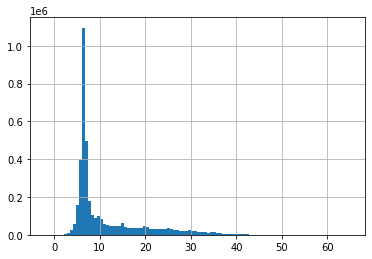

In [37]:
test_avg["pressure"].hist(bins=100)
plt.show()

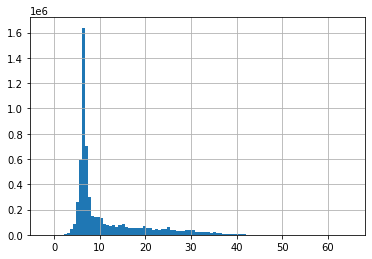

In [38]:
train["pressure"].hist(bins=100)
plt.show()